# Comparing topic models

In this notebook, we sense check our BERTopic model by comparing it with that of LDA and Top2Vec. 

BERTopic is by considerable margins the most complicated technique of all three of these models due to its sentence transformer embeddings; but that is not to say it is best. BERTopic is also the most time-consuming framework to implement, and if we were to see diminishing returns, then we might instead wish to opt for a simpler model.

## LDA (Latent Dirichlet Allocation)

LDA remains exceedingly popular in recent academic research. This is likely mostly due to how established it is as a topic modelling technique. But its 'cheap and cheerful' implementation can also provide a core advantage where the goal is to create a quick and straightforward representation of text. 

LDA assumes that documents are composed of words that can determine latent topics. It therefore does not assume that input documents can only have one topic, and consequently is not primarily concerned with identifying topics at a document-level. 

LDA is semantically blind. As such, an LDA model will not attempt to create topics composed of semantically similar words or phrases. We must also pre-specify the number of topics to analyse, as there is no unsupervised clustering algorithm that is applied to the data, unlike in BERTopic.

### Preprocessing

Unlike BERTopic, LDA demands that we heavily preprocess our data, tokenising, lemmatizing and removing stop words.

In [1]:
import pandas as pd

data = pd.read_csv('../Data/processed_paragraphs.csv')
text = data['ProcessedParagraph']
text

0       Pre-amble They were a 52-year-old male with no...
1       On a date, they contacted the CRISIS Home Reso...
2       Multi-Disciplinary Team (“MDT”) Meetings I am ...
3       Risk assessments At the initial triage (undert...
4       Discharge They were discharged from the care o...
                              ...                        
1243    It is known that a prisoner's risk of self-har...
1244    The PPO report recommended that an ACCT should...
1245    The healthcare screening, which is a question-...
1246    Some prisoners at HMP Peterborough are allowed...
1247    In addition, the deceased referred to experime...
Name: ProcessedParagraph, Length: 1248, dtype: object

In [5]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import pandas as pd

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define stop words
stop_words = set(stopwords.words('english'))

# Define a function for lowercasing, removing special characters, and removing numbers
def preprocess_text(text):
    return ''.join(char.lower() if char.isalpha() or char.isspace() else ' ' for char in text)

# Define a function for tokenizing text
def tokenize(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha()]
    return [word for word in words if word not in stop_words]

# Define a function to remove stop words
def remove_stopwords(text):
    words = text.split()
    return ' '.join(word for word in words if word not in stop_words)

# Apply text preprocessing to the content
processed_text = text.apply(preprocess_text)

# Remove stop words from the preprocessed content
processed_text = processed_text.apply(remove_stopwords)

# Apply word tokenization and pre-processing to the content
processed_text = processed_text.apply(tokenize)


## Lemmatize the text

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, download
from nltk.corpus import wordnet

# Download NLTK data
download('averaged_perceptron_tagger')
download('wordnet')

# Map POS tags for lemmatization
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Initialise the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens
def lemmatize_tokens(tokens):
    try:
        # POS tagging
        pos_tags = pos_tag(tokens)
        # Lemmatize with POS tags
        return [lemmatizer.lemmatize(token, get_wordnet_pos(tag) or wordnet.NOUN) for token, tag in pos_tags]
    except Exception as e:
        print(f"Error processing content: {e}")
        return []


# Apply lemmatization to the preprocessed content
processed_text = processed_text.apply(lemmatize_tokens)


processed_text


[nltk_data] Downloading package punkt to /home/sam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/sam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0       [pre, amble, year, old, male, history, mental,...
1       [date, contact, crisis, home, resolution, trea...
2       [multi, disciplinary, team, mdt, meeting, conc...
3       [risk, assessment, initial, triage, undertaken...
4       [discharge, discharge, care, lpt, plan, suppor...
                              ...                        
1243    [know, prisoner, risk, self, harm, suicide, ma...
1244    [ppo, report, recommend, acct, open, whenever,...
1245    [healthcare, screen, question, answer, discuss...
1246    [prisoner, hmp, peterborough, allow, carry, ce...
1247    [addition, decease, referred, experimentation,...
Name: ProcessedParagraph, Length: 1248, dtype: object

Next, we need to make a document-term matrix. This is created by counting the occurrence of every term in each piece of text and then normalising the counts to create a matrix of values.

In [9]:
### Create document-term matrix
from gensim import corpora

# Creating document-term matrix 
dictionary = corpora.Dictionary(processed_text)

doc_term_matrix = [dictionary.doc2bow(doc) for doc in processed_text]

# Print first 30 matrix entries
print(doc_term_matrix[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 1), (23, 2), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1)]


Since LDA cannot ascertain the ideal number of topics itself, we must provide a 'number of topics parameter'. 

We can do this through testing for 'perplexity'. Perplexity measures the ability of our model to predict the next word in unseen or held-out documents. A lower perplexity score indicates better model performance.

Number of topics: 2, Perplexity: -7.207142216859145
Number of topics: 22, Perplexity: -7.945009634622128
Number of topics: 42, Perplexity: -8.539157043259504
Number of topics: 62, Perplexity: -9.027604773293936
Number of topics: 82, Perplexity: -9.494957582270368
Number of topics: 102, Perplexity: -9.795971945924432
Number of topics: 122, Perplexity: -10.173976383835775
Number of topics: 142, Perplexity: -10.536502653497168
Number of topics: 162, Perplexity: -10.824782847689283
Number of topics: 182, Perplexity: -11.210767463874054
Number of topics: 202, Perplexity: -11.478243240679483
Number of topics: 2, Perplexity: -7.207142216859145
Number of topics: 22, Perplexity: -7.945009634622128
Number of topics: 42, Perplexity: -8.539157043259504
Number of topics: 62, Perplexity: -9.027604773293936
Number of topics: 82, Perplexity: -9.494957582270368
Number of topics: 102, Perplexity: -9.795971945924432
Number of topics: 122, Perplexity: -10.173976383835775
Number of topics: 142, Perplexity:

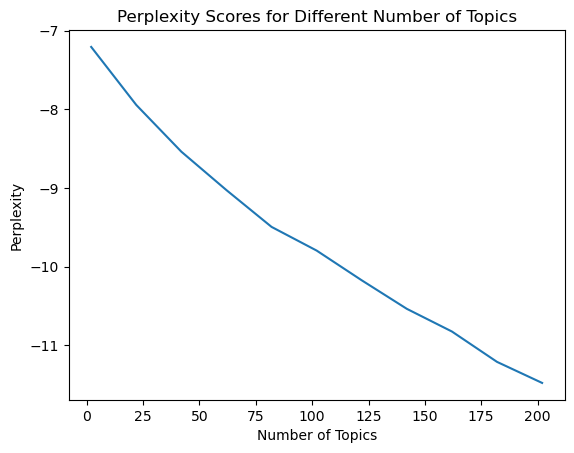

In [21]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Function to calculate perplexity for different numbers of topics
def compute_perplexity(dictionary, doc_term_matrix, texts, start, limit, step):
    perplexity_values = []
    for num_topics in range(start, limit, step):
        lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, random_state=100)
        perplexity = lda_model.log_perplexity(doc_term_matrix)
        perplexity_values.append((num_topics, perplexity))
        print(f'Number of topics: {num_topics}, Perplexity: {perplexity}')
    return perplexity_values

# Calculate perplexity for different numbers of topics
start = 2  # minimum number of topics
limit = 203  # maximum number of topics
step = 20  # step size to vary the number of topics

perplexity_values = compute_perplexity(dictionary, doc_term_matrix, processed_text, start, limit, step)

# Print the perplexity scores
for num_topics, perplexity in perplexity_values:
    print(f'Number of topics: {num_topics}, Perplexity: {perplexity}')

## Plot it!
import matplotlib.pyplot as plt

x = [num_topics for num_topics, perplexity in perplexity_values]
y = [perplexity for num_topics, perplexity in perplexity_values]

plt.plot(x, y)
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("Perplexity Scores for Different Number of Topics")
plt.show()



Number of topics: 2, Coherence: 0.32461024566826047
Number of topics: 22, Coherence: 0.3517035132209032
Number of topics: 42, Coherence: 0.3242452688111365
Number of topics: 62, Coherence: 0.31439158215219365
Number of topics: 82, Coherence: 0.32711556246005347
Number of topics: 102, Coherence: 0.31742587528733024
Number of topics: 122, Coherence: 0.3125572036490713
Number of topics: 142, Coherence: 0.307912880573399
Number of topics: 162, Coherence: 0.3180892857713047
Number of topics: 182, Coherence: 0.31213404617275614
Number of topics: 202, Coherence: 0.3067992023475855


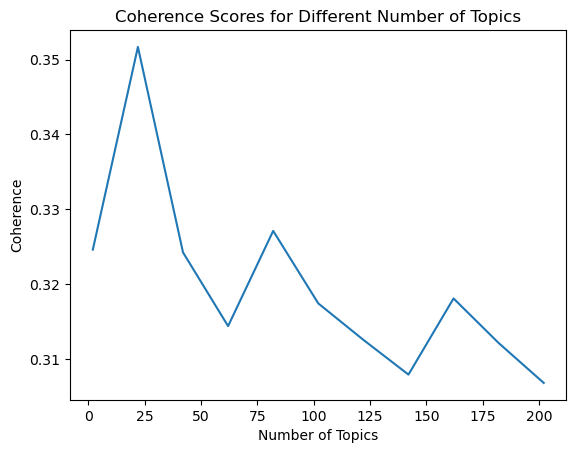

In [31]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence(dictionary, doc_term_matrix, texts, start, limit, step):
    coherence_values = []
    for num_topics in range(start, limit, step):
        lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, random_state=100)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model.get_coherence()
        coherence_values.append((num_topics, coherence))
        print(f'Number of topics: {num_topics}, Coherence: {coherence}')
    return coherence_values

# Calculate coherence for different numbers of topics
coherence_values = compute_coherence(dictionary, doc_term_matrix, processed_text, start, limit, step)

# Plot coherence scores
x = [num_topics for num_topics, coherence in coherence_values]
y = [coherence for num_topics, coherence in coherence_values]

plt.plot(x, y)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.title("Coherence Scores for Different Number of Topics")
plt.show()


The graphs aren't great. Our perplexity score continues to decrease almost linearly, with no sign of any diminishing returns as we might expect. This could suggest that our reports are far too heterogeneous to model within a restrictive number of topics, under LDA assumptions.

The coherence scores generally get worse as the number of topics increases, though it seems to settle on 25 topics as the optimal value.

Therefore, we'll run an LDA topic model with the number of topics set as 25.

In [41]:
lda_model = LdaModel(doc_term_matrix, num_topics=25, id2word=dictionary, random_state=100)
pprint(lda_model.print_topics())

[(23,
  '0.013*"evidence" + 0.013*"risk" + 0.011*"may" + 0.010*"patient" + '
  '0.010*"mental" + 0.010*"health" + 0.009*"concern" + 0.009*"death" + '
  '0.008*"assessment" + 0.008*"inquest"'),
 (14,
  '0.017*"evidence" + 0.016*"individual" + 0.012*"team" + 0.010*"may" + '
  '0.010*"health" + 0.009*"information" + 0.007*"access" + 0.007*"service" + '
  '0.007*"risk" + 0.007*"concern"'),
 (8,
  '0.013*"risk" + 0.009*"staff" + 0.008*"evidence" + 0.008*"mental" + '
  '0.008*"would" + 0.008*"give" + 0.007*"health" + 0.007*"self" + '
  '0.007*"trust" + 0.007*"assessment"'),
 (22,
  '0.016*"risk" + 0.013*"health" + 0.011*"care" + 0.011*"mental" + '
  '0.010*"death" + 0.010*"patient" + 0.009*"assessment" + 0.009*"individual" + '
  '0.009*"take" + 0.009*"evidence"'),
 (18,
  '0.013*"prison" + 0.012*"staff" + 0.011*"make" + 0.008*"risk" + '
  '0.008*"discharge" + 0.008*"patient" + 0.007*"hmp" + 0.007*"report" + '
  '0.007*"prisoner" + 0.007*"take"'),
 (3,
  '0.009*"assessment" + 0.008*"care" + 0

In [45]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus=doc_term_matrix, dictionary=dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.032636 -0.027492       1        1  10.907441
2     -0.006341 -0.033812       2        1   8.261250
11    -0.202453 -0.048966       3        1   8.239610
22     0.013819 -0.034391       4        1   8.105521
24     0.033983 -0.036330       5        1   7.936973
4      0.031005 -0.018712       6        1   7.585322
7      0.018067 -0.023432       7        1   6.280487
9      0.039496 -0.022982       8        1   5.716089
23    -0.033553 -0.025408       9        1   5.141193
20     0.030560 -0.001810      10        1   4.301991
5      0.027615 -0.016893      11        1   2.957707
8      0.040623 -0.002401      12        1   2.656895
10     0.030553  0.009068      13        1   2.563620
3      0.034319  0.002286      14        1   2.522825
13     0.041319 -0.008765      15        1   2.447791
14     0.037205 -0.006383      16        1   2.118029
16    -0.003884  0.024159      17        1   2.091032
21     0.028758  0.013101      18        1   1.914276
0      0.007402  0.001870      19        1   1.802650
15     0.018999  0.064295      20        1   1.371283
18     0.005740  0.003244      21        1   1.289864
17     0.058096  0.031693      22        1   1.125662
6     -0.054946  0.017615      23        1   1.100759
12    -0.192813  0.018669      24        1   0.991484
19    -0.036207  0.121776      25        1   0.570242, topic_info=             Term        Freq       Total Category  logprob  loglift
271           may  457.000000  457.000000  Default  30.0000  30.0000
886       coroner  209.000000  209.000000  Default  29.0000  29.0000
491          copy  192.000000  192.000000  Default  28.0000  28.0000
1165        chief  172.000000  172.000000  Default  27.0000  27.0000
803      response  298.000000  298.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
107          also    1.191443  182.341341  Topic25  -5.6109   0.1361
306       service    1.209259  338.439198  Topic25  -5.5961  -0.4675
968   observation    1.085145   78.032401  Topic25  -5.7043   0.8915
954       respond    1.061070   69.307980  Topic25  -5.7268   0.9876
32         mental    1.082165  525.934321  Topic25  -5.7071  -1.0193

[1894 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
4247     17  0.639297             aau
56        1  0.225750            able
56        2  0.048375            able
56        3  0.048375            able
56        4  0.016125            able
...     ...       ...             ...
4440      4  0.506591            zero
3778      7  0.369548        zolpidem
3778     13  0.369548        zolpidem
1617      2  0.389942  zuclopenthixol
1617     22  0.389942  zuclopenthixol

[6530 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 12, 23, 25, 5, 8, 10, 24, 21, 6, 9, 11, 4, 14, 15, 17, 22, 1, 16, 19, 18, 7, 13, 20])

The LDA model demonstrates somewhat interpretable topics. For instance, we can see that topics 3 and 24 are outlier topics, reflecting template text contained within the reports. These are very distant from the other, more meaningful topics.

However, the model falls short on a number of counts. Topics 1 and 2 share the same top-4 words, while there are 7 topics that contain the word 'risk' in the top-3 keywords. 

We can observe some similarities between our LDA model and our BERTopic model (for instance, both models highlight a number of different topics that all relate to prisons), but the interpretation of these topics appears far too difficult for it to usefully contribute to any wider learnings from PFD reports. 

## Top2Vec

Top2Vec can be seen as straddling the border between LDA and BERTopic. 

Like BERTopic, Top2Vec makes use of sentence embeddings to create a multi-dimensional vector representation of text. However, it is drastically less customisable than BERTopic, meaning you can't swap out any sentence embeddings model from HuggingFace. Ironically, the best embeddings model in Top2Vec is BERT. 

However, it shares some similarities with LDA in that it partly assumes that topics are generated from the distribution of words across documents. In Top2Vec, the document- and word embeddings lie in the same vector space and subsequent clustering therefore typically contains a mixture of documents and words. Contrastingly, BERTopic only models the documents in this vector space and **then** seeks to uncover representative words or phrases.

Another interesting point of differentiation between Top2Vec and BERTopic is the former looks at the centroid of a cluster when composing its topic representations, while BERTopic draws on the entire cluster. This means that Top2Vec could be beneficial where you want a precise and narrow topic representation, while BERTopic could be advantageous where you are happy for topics to contain heterogeneity. 

So overall, Top2Vec can be better suited if we want to capture the relationship between individual words and documents. It's useful for cases where understanding how specific words contribute to the overall topic is important. By contrast, BERTopic is perhaps more useful if you want to focus more on the broader context and meaning of documents as a whole, and you don't necessarily care about aligning word and document vectors in the same space. It's often preferred for more nuanced, context-aware topic modeling.

In [2]:
# Make sure 'text' is a list of strings
text = text.tolist()

In [28]:
from top2vec import Top2Vec

umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'min_dist': 0.2,
             'metric': 'cosine',
             "random_state": 230624}

hdbscan_args = {'min_cluster_size': 10,
                'min_samples':5,
                'metric': 'euclidean',
                'cluster_selection_method': 'leaf'}

top2vec_model = Top2Vec(documents=text, speed="learn", workers=4,
                        embedding_model="distiluse-base-multilingual-cased",
                        umap_args=umap_args, hdbscan_args=hdbscan_args)

topic_sizes, topic_nums = top2vec_model.get_topic_sizes()

print(f"\n\nThere are {len(topic_sizes)} topics. The sizes of the topics are:")
# Print each number of 'topic_sizes' via a for loop
for i in range(len(topic_sizes)):
          print(f"Topic {topic_nums[i]}: {topic_sizes[i]}")


2024-08-07 16:51:21,020 - top2vec - INFO - Pre-processing documents for training
/home/sam/miniconda3/envs/top2vec_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2024-08-07 16:51:21,252 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
2024-08-07 16:51:22,062 - top2vec - INFO - Creating joint document/word embedding
2024-08-07 16:52:05,435 - top2vec - INFO - Creating lower dimension embedding of documents
2024-08-07 16:52:09,725 - top2vec - INFO - Finding dense areas of documents
2024-08-07 16:52:09,790 - top2vec - INFO - Finding topics




There are 28 topics. The sizes of the topics are:
Topic 0: 162
Topic 1: 85
Topic 2: 69
Topic 3: 69
Topic 4: 68
Topic 5: 57
Topic 6: 51
Topic 7: 51
Topic 8: 50
Topic 9: 50
Topic 10: 49
Topic 11: 46
Topic 12: 41
Topic 13: 41
Topic 14: 37
Topic 15: 36
Topic 16: 34
Topic 17: 33
Topic 18: 33
Topic 19: 27
Topic 20: 25
Topic 21: 24
Topic 22: 24
Topic 23: 20
Topic 24: 20
Topic 25: 17
Topic 26: 16
Topic 27: 13


Top2Vec identifies a similar number of topics as BERTopic. However, Top2Vec does not produce a "-1" outlier topic unlike BERTopic, despite also using the HDBSCAN clustering model. This is because following the clustering, Top2Vec assigns outlier topics to the nearest non-outlier cluster. This is perhaps a core disadvantage of Top2Vec for our particular use case, as outlier topics are actually desireable, as it means that identified themes would be more likely to be meaningful. 

We can now inspect the keywords and representative documents associated with each topic.

In [38]:
for topic in topic_nums:
    print(f"\nTopic {topic}")
    print(top2vec_model.topic_words[topic])
    print(f"\nRepresentative document of topic {topic}:")
    print(top2vec_model.search_documents_by_topic(topic_num=topic, num_docs=3))

#top2vec_model.topic_words[0]


Topic 0
['risk' 'risks' 'no' 'safety' 'not' 'two' 'without' 'emergency' 'document'
 'trust' 'nurse' 'ensure' 'due' 'assessment' 'hospital' 'contain' 'police'
 'recorded' 'summary' 'review' 'evidence' 'clinical' 'available' 'records'
 'have' 'assessments' 'had' 'patients' 'completed' 'did' 'complete'
 'record' 'heard' 'including' 'medical' 'identified' 'with' 'timetable'
 'team' 'very' 'has' 'report' 'coordinator' 'relevant' 'now' 'was' 'above'
 'received' 'were' 'there']

Representative document of topic 0:
(array(['Evidence was heard regarding the manner in which information crucial to the formulation of risk assessments was recorded and shared: a) Two types of risk assessments were completed, with no system to ensure that important information is present on both; b) The previous incident in which an individual had attempted to take their own life in very similar circumstances on the ward was not clearly entered on the risk assessments used by staff and therefore not known to a numbe

## Final thoughts

This notebook has considered the extent to which LDA and Top2Vec may be effective at modelling the coroner concerns contained within PFD reports. We find that:

* LDA does a generally poor job, demonstrated through the regular occurance of the same key words for multiple topics. This makes it very difficult to interpret topics as their own distinct entity. 
* Deciding upon the number of topics for LDA also feels somewhat arbitrary. Perplexity scores show no diminishing returns for modelling a greater number of topics. Coherence scores do seem to indicate that 25 topics is the optimal number, which validates the findings of our Top2Vec model, which also seemed to arrive at a similar number of topics.
* Top2Vec doesn't appear to drastically outperform LDA. The keywords 'psychiatric' and 'clinical' appear in multiple topics, leaving little unique value of many individual topics. 
* While we shouldn't remove stop words in any model using transformer embeddings (for they carry a large amount of sematinc context) it is interesting to note their presence in many topics. 

Additionally, a broader issue with LDA and Top2Vec may not simply be their topic representations, but rather the broader functionality of the packages. LDA contains no out-of-the-box approach for identifying representative documents, and takes a heavily linguistic approach to identifying topics. This is great for academic inquiry, but less suitable to support a system document-level categorisation system that would improve PFD report learnings. 

Similarly, Top2Vec is challenging to customise. There appears to be no way to prevent it from allocating outlier documents to a non-outlier cluster. Additionally, the presence of stop words in topic representations and its lack of modularity when it comes to sentence transformer models makes the approach feel somewhat fragile. I would not be confident, for example, that we could duplicate our Top2Vec model across different categories of PFD reports and expect to see meaningful results.